## Model 3
- Pop, total crime (2017), median income

In [1]:
import pandas as pd
import os
import geopandas as gp
import fiona
import numpy as np
from choropleth import choroplethNYC as cp
import matplotlib.pylab as plt
import pylab as pl

In [2]:
os.getcwd()

'/Users/christine_biddlecombe/CJA/patrol_allocation'

In [3]:
files = os.listdir()

In [4]:
files = [file for file in files if file[-3:]=='csv']
names = [file[:-4] for file in files]

In [5]:
frames = []
for file, name in zip(files, names):
    name = pd.read_csv(file)
    frames.append(name)

In [6]:
files

['age_precinct.csv',
 '2016_estimations.csv',
 'StopFrisk_10thru18R.csv',
 'adjusted_day_MODEL_RESULTS.csv',
 'complaint_data.csv',
 'tract_precinct_key.csv',
 'pluto.csv',
 'precinct_pop_m.csv',
 'area_model_results.csv',
 'acs_other_demo_data.csv',
 'seven_majors.csv',
 'plutocounts.csv',
 'crash_data.csv',
 'precinct_population_dayadjust.csv',
 'vacancy_only.csv',
 'plutoSums.csv']

# Population

In [7]:
pop = frames[7] #refers to precinct_pop_m.csv

In [8]:
pop2 = pop[['precinct_me', 'total_pop2017']]

In [9]:
pop2.head()

,precinct_me,total_pop2017
0,1.0,75871
1,5.0,50839
2,6.0,59687
3,7.0,59018
4,9.0,75718


# Crime

In [10]:
complaint = frames[4]

In [11]:
complaint2 = complaint[['ADDR_PCT_CD', 'total2017']]
complaint2.head()

,ADDR_PCT_CD,total2017
0,1,5935.0
1,10,3586.0
2,100,2684.0
3,101,4283.0
4,102,4829.0


## Merging dfs

In [12]:
## merge the dataframes
popComplaint = pd.merge(complaint2, pop2, left_on='ADDR_PCT_CD',
                  right_on='precinct_me')

In [13]:
popComplaint.rename(columns={'total2017':'crime',
                            'total_pop2017':'population'},
                   inplace=True)

In [14]:
popComplaint.drop('precinct_me', axis=1, inplace=True)

In [15]:
popComplaint.head()

,ADDR_PCT_CD,crime,population
0,1,5935.0,75871
1,10,3586.0,49476
2,100,2684.0,52075
3,101,4283.0,70937
4,102,4829.0,137972


# Adding in Median Income

In [16]:
acs = frames[9]
acs2 = acs[['precinct', 'median_fam_income']]

In [17]:
acs2.head()

,precinct,median_fam_income
0,1.0,202088.076923
1,5.0,83063.454545
2,6.0,203360.416667
3,7.0,60776.700000
4,9.0,102720.785714


# Merging Again

In [19]:
final = popComplaint.merge(acs2, left_on='ADDR_PCT_CD',
                          right_on='precinct')

In [21]:
final.drop('precinct', axis=1, inplace=True)

In [22]:
final.head()

,ADDR_PCT_CD,crime,population,median_fam_income
0,1,5935.0,75871,202088.076923
1,10,3586.0,49476,153792.909091
2,100,2684.0,52075,94526.166667
3,101,4283.0,70937,52757.666667
4,102,4829.0,137972,70808.826923


## Creating Rates, Creating Column that represents sums of all rates

In [23]:
final['crime_pct'] = final.crime / final.crime.sum()
final['pop_pct'] = final.population / final.population.sum()
final['median_income_pct'] = final.median_fam_income / final.median_fam_income.sum()

In [24]:
final.head()

,ADDR_PCT_CD,crime,population,median_fam_income,crime_pct,pop_pct,median_income_pct
0,1,5935.0,75871,202088.076923,0.012960,0.008887,0.031171
1,10,3586.0,49476,153792.909091,0.007831,0.005795,0.023722
2,100,2684.0,52075,94526.166667,0.005861,0.006100,0.014580
3,101,4283.0,70937,52757.666667,0.009353,0.008309,0.008138
4,102,4829.0,137972,70808.826923,0.010545,0.016161,0.010922


In [25]:
# creating value for total rates of all measures rate per precinct
final['all_rates']= final.iloc[:,4:7].sum(axis=1)

In [26]:
# creating new column as a percentage of total crime in the city, based sum of total_crime column
# each value will represent the share of total crime that occurs in that precinct 
final['total_share'] = (final.all_rates / final.all_rates.sum())

In [27]:
final['total_share'].sum()

1.0

## Multiply Rates by 20000 to get patrol allocation by precinct

In [28]:
final['allocation'] = final.total_share * 20000

In [29]:
final['allocation'] = final['allocation'].astype(int)

In [30]:
#crimeRates.rename(columns={'ADDR_PCT_CD':'precinct'}, inplace=True)

In [31]:
final.describe()

,ADDR_PCT_CD,crime,population,median_fam_income,crime_pct,pop_pct,median_income_pct,all_rates,total_share,allocation
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,63.868421,6025.486842,112334.618421,85305.939872,0.013158,0.013158,0.013158,0.039474,0.013158,262.605263
std,36.039734,2343.723963,48775.474549,48406.447195,0.005118,0.005713,0.007466,0.009532,0.003177,63.586179
min,1.000000,2491.000000,12716.000000,28925.307692,0.005440,0.001489,0.004462,0.021136,0.007045,140.000000
25%,32.750000,4337.000000,74600.500000,52678.435484,0.009471,0.008738,0.008125,0.033061,0.011020,219.500000
50%,66.500000,5760.000000,108809.000000,71672.713462,0.012578,0.012745,0.011055,0.038159,0.012720,254.000000
75%,100.250000,6957.500000,146905.000000,95031.833333,0.015193,0.017207,0.014658,0.044771,0.014924,297.750000
max,123.000000,14745.000000,237772.000000,215515.071429,0.032199,0.027851,0.033242,0.071576,0.023859,477.000000


In [46]:
# acsOutlier = acsF2[acsF2.allocation == 762]
# acsOutlier.head()

In [47]:
# crimeRates.iloc[crimeRates['total_crime_share'].argmax()] # find column with max in total_Crime_share column, 
                                                          # print associated values 

In [48]:
# crimeRates.iloc[crimeRates['total_crime_share'].argmin()] # find column with min in total_Crime_share column, 
                                                          # print associated values 

## Merging in Shapefile to Visualize Allocations

In [32]:
url = 'https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=Shapefile'
precinct = gp.GeoDataFrame.from_file(url)
precinct.head(2)

,precinct,shape_area,shape_leng,geometry
0,1.0,4.730176e+07,80586.154615,(POLYGON ((-74.0438776157395 40.69018767637665...
1,5.0,1.808880e+07,18676.124259,POLYGON ((-73.98863862848766 40.72293372026369...


In [33]:
patrol = pd.merge(precinct, final, 
                      left_on='precinct',
                     right_on='ADDR_PCT_CD')

In [34]:
patrol.to_crs(epsg=2263, inplace=True)

Text(0.5,1,'Allocations Based on Population and Total Crime')

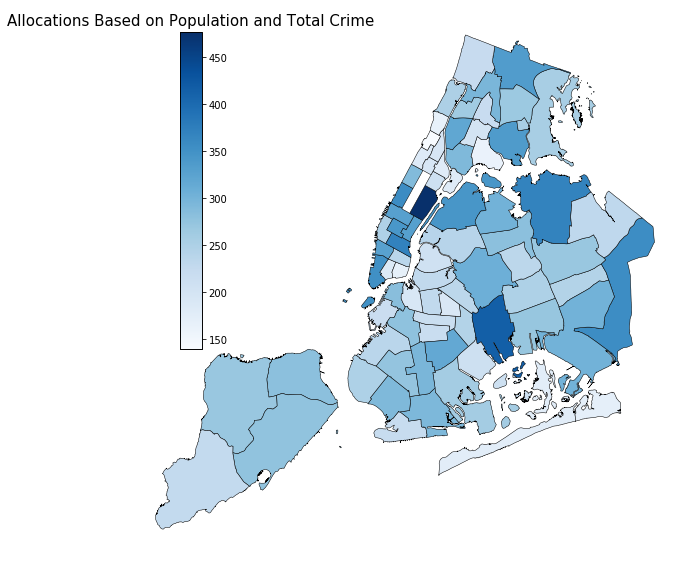

In [35]:
cp(patrol, column='allocation', cmap="Blues", edgecolor="black",lw=.5)
plt.title('Allocations Based on Population and Total Crime' ,fontsize=(15))

Figure 1: Looks pretty good

In [38]:
## Removing outlier and then plotting again 

In [39]:
# patrol_noOutlier = patrol[patrol.allocation != 762]

In [54]:
# cp(patrol_noOutlier, column='allocation', cmap="Blues", edgecolor="black", lw=.5)
# plt.title('Allocations Based on ACS, Vacancy, Etc.' ,fontsize=(15));

# Reading in 2016 Patrol Allocations

- these are best estimates

In [36]:
patrol16 = pd.read_csv('2016_estimations.csv')
patrolGeo = pd.merge(precinct, patrol16, 
                      left_on='precinct',
                     right_on='precinct')

In [37]:
patrolGeo.to_crs(epsg=2263, inplace=True)

In [38]:
# patrolGeo.total_po.replace('inf', np.nan, inplace=True)
# patrolGeo.total_po.replace(NaN, np.nan, inplace=True)

In [39]:
patrolGeo.drop([29], inplace=True)

In [40]:
patrolGeo.dropna(how='any', axis=0, inplace=True)

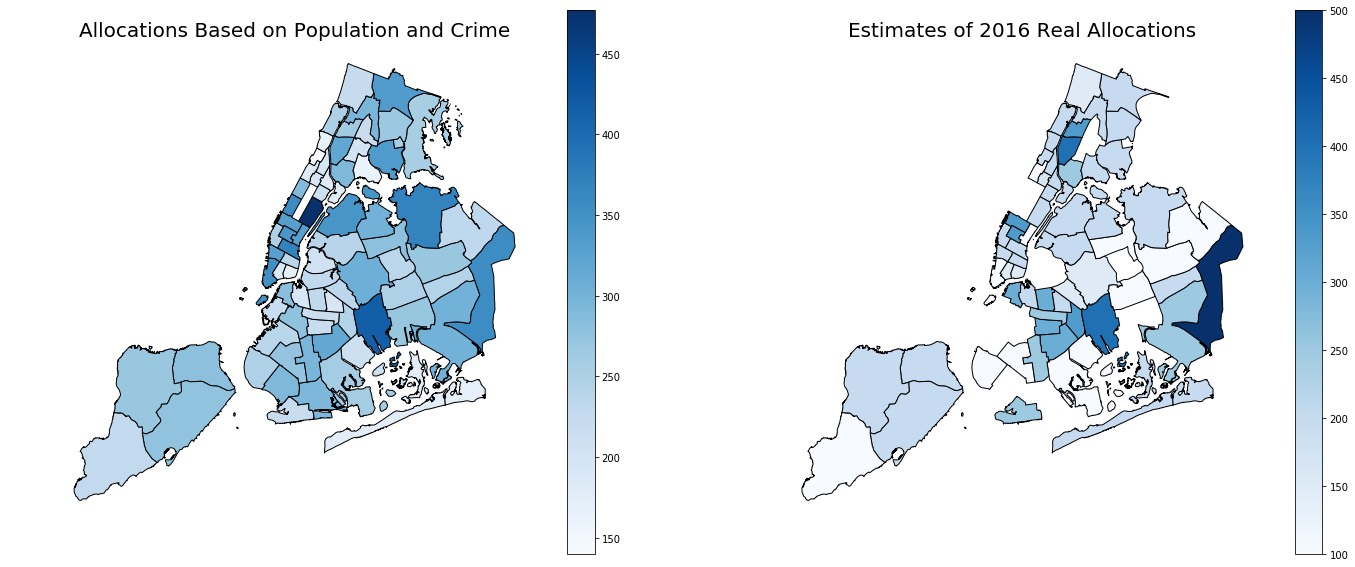

In [41]:
fig = pl.figure(figsize=(50,10))

ax1 = fig.add_subplot(141)
ax1.set_title('Allocations Based on Population and Crime', fontsize=20)
patrol.plot(column='allocation', cmap='Blues',
                      ax=ax1, legend=True, edgecolor='black')
ax1.axis('off')

ax2 = fig.add_subplot(142)
ax2.set_title('Estimates of 2016 Real Allocations', fontsize=20)
patrolGeo.plot(column='total_po', cmap='Blues', 
               ax=ax2, legend=True, edgecolor='black')
ax2.axis('off');